
# 1D Plug-Flow Reactor (PFR) with RMG Ammonia Mechanism in Cantera

This notebook shows how to take the RMG-exported Cantera YAML for ammonia oxidation and run a 1D isothermal plug-flow reactor (PFR) using Cantera's `FlowReactor`. It mirrors the jet-stirred reactor example but along distance, so students can reproduce axial profiles and compare to experiment.



## What you need
- Run from the `RMG-Py` repository root.
- Dependencies: `cantera`, `pyyaml`, `numpy`, `matplotlib`.
- We optionally fix duplicate-reaction markings in the RMG Cantera file before running, just as in the JSR notebook.


In [1]:
"""
t3 utils fix_cantera module
A module to automatically fix issues with RMG-generated Cantera files, mainly resolving mislabeled duplicate reactions.
"""
import os

from typing import List, Optional, Union

import shutil
import time
import traceback
import yaml
import cantera as ct


class InputError(Exception):
    """Raised when an input to the Cantera-fixing utilities is invalid."""
    pass

def globalize_paths(path: str, project_directory: str) -> str:
    """
    Convert a relative path into an absolute path based on project_directory.
    If path is already absolute, return it unchanged.
    """
    if os.path.isabs(path):
        return path
    return os.path.normpath(os.path.join(project_directory, path))


def read_yaml_file(path: str,
                   project_directory: Optional[str] = None,
                   ) -> Union[dict, list]:
    """
    Read a YAML file (usually an input / restart file, but also conformers file)
    and return the parameters as python variables.

    Args:
        path (str): The YAML file path to read.
        project_directory (str, optional): The current project directory to rebase upon.

    Returns: Union[dict, list]
        The content read from the file.
    """
    if project_directory is not None:
        path = globalize_paths(path, project_directory)
    if not isinstance(path, str):
        raise InputError(f'path must be a string, got {path} which is a {type(path)}')
    if not os.path.isfile(path):
        raise InputError(f'Could not find the YAML file {path}')
    with open(path, 'r') as f:
        content = yaml.load(stream=f, Loader=yaml.FullLoader)
    return content

def to_yaml(py_content: Union[list, dict]) -> str:
    """
    Convert a Python list or dictionary to a YAML string format.

    Args:
        py_content (list, dict): The Python content to save.

    Returns: str
        The corresponding YAML representation.
    """
    yaml.add_representer(str, string_representer)
    yaml_str = yaml.dump(data=py_content)
    return yaml_str


def string_representer(dumper, data):
    """
    Add a custom string representer to use block literals for multiline strings.
    """
    if len(data.splitlines()) > 1:
        return dumper.represent_scalar(tag='tag:yaml.org,2002:str', value=data, style='|')
    return dumper.represent_scalar(tag='tag:yaml.org,2002:str', value=data)

def save_yaml_file(path: str,
                   content: Union[list, dict],
                   ) -> None:
    """
    Save a YAML file (usually an input / restart file, but also conformers file).

    Args:
        path (str): The YAML file path to save.
        content (list, dict): The content to save.
    """
    if not isinstance(path, str):
        raise InputError(f'path must be a string, got {path} which is a {type(path)}')
    yaml_str = to_yaml(py_content=content)
    if '/' in path and os.path.dirname(path) and not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    with open(path, 'w') as f:
        f.write(yaml_str)


def get_traceback(model_path: str) -> Optional[str]:
    """
    Try loading the Cantera model and return the traceback if it fails.

    Args:
        model_path (str): The path to the cantera YAML model file.

    Returns:
        Optional[str]: The traceback if the model fails to load.
    """
    tb = None
    try:
        ct.Solution(model_path)
    except ct.CanteraError:
        tb = traceback.format_exc()
    return tb


def fix_cantera(model_path: str):
    """
    Fix a Cantera model that has incorrectly marked duplicate reactions.
    Creates a backup copy of the Cantera model and fixes the content of the original file in place.

    Args:
        model_path (str): The path to the cantera YAML model file.

    Returns:
        bool: Whether the model was fixed.
    """
    shutil.copyfile(model_path, model_path + '.bak')
    done, fixed = False, False
    counter = 0
    while not done and counter < 1000:
        counter += 1
        tb = get_traceback(model_path)
        if tb is None:
            done = True
            break
        else:
            if 'Undeclared duplicate reactions detected' in tb:
                fix_undeclared_duplicate_reactions(model_path, tb)
                fixed = True
            elif 'No duplicate found for declared duplicate reaction' in tb:
                fix_no_duplicate_found(model_path, tb)
                fixed = True
            else:
                print(f'Could not fix {model_path}:\n\n{tb}')
                break
        time.sleep(1)
    if fixed:
        print(f'Fixing Cantera model {model_path} (and creating a backup copy with a .bak extension).')
    else:
        os.remove(model_path + '.bak')
    return done


def fix_undeclared_duplicate_reactions(model_path: str, tb: str):
    """
    Fix a Cantera model that has undeclared duplicate reactions.

    Args:
        model_path (str): The path to the cantera YAML model file.
        tb (str): The traceback.
    """
    content = read_yaml_file(model_path)
    rxns = get_dup_rxn_indices(tb)
    print(f'Marking reactions {", ".join([str(r) for r in rxns])} as duplicate.')
    for i in rxns:
        content['reactions'][i - 1]['duplicate'] = True
    save_yaml_file(model_path, content)


def fix_no_duplicate_found(model_path: str, tb: str):
    """
    Fix a Cantera model that has a reaction marked as duplicate by mistake with no other duplicate reaction.

    Args:
        model_path (str): The path to the cantera YAML model file.
        tb (str): The traceback.
    """
    content = read_yaml_file(model_path)
    rxns = get_mistakenly_marked_dup_rxns(tb)
    for i in rxns:
        if 'duplicate' in content['reactions'][i].keys():
            print(f'Marking reaction {i} as non-duplicate.')
            del content['reactions'][i]['duplicate']
    save_yaml_file(model_path, content)


def get_dup_rxn_indices(tb: str) -> List[int]:
    """
    Get the duplicate reactions from the traceback.

    Args:
        tb (str): The traceback.

    Returns:
        List[int]: The reactions indices.
    """
    rxns = list()
    if tb is None:
        return rxns
    lines = tb.split('\n')
    read = False
    for line in lines:
        if 'Undeclared duplicate reactions detected:' in line:
            read = True
        if '|  Line |' in line:
            break
        if read and 'Reaction' in line:
            rxns.append(int(line.split()[1].split(':')[0]))
    return rxns


def get_mistakenly_marked_dup_rxns(tb: str) -> List[int]:
    """
    Get the duplicate reactions from the traceback.

    Args:
        tb (str): The traceback.

    Returns:
        List[int]: The reactions indices.
    """
    rxns = list()
    if tb is None:
        return rxns
    lines = tb.split('\n')
    for line in lines:
        if 'No duplicate found for declared duplicate reaction number' in line:
            rxns.append(int(line.split()[8]))
    return rxns


## Fix the RMG-generated Cantera file (optional)
If Cantera raises duplicate-reaction bookkeeping errors, the helper below will patch the YAML in place and keep a `.bak` copy. If the file loads cleanly, nothing is changed.


In [2]:

model_path = "dmf.cti"

# Only modifies the YAML if Cantera reports duplicate bookkeeping issues.
_ = fix_cantera(model_path)


/tmp/ipykernel_709245/913330766.py:108: DeprecationWarning: XML_Node::build: 
The CTI and XML input file formats are deprecated and will be removed in
Cantera 3.0. Use 'cti2yaml.py' or 'ctml2yaml.py' to convert CTI or XML input
files to the YAML format. See https://cantera.org/tutorials/legacy2yaml.html
for more information.
  ct.Solution(model_path)



## Handle RMG species names
Species names include numeric identifiers (e.g., `NH3(1)`). The helper returns the full Cantera species name from a base label so you don't have to track the numbering manually.


In [3]:
def get_species(gas, name):
    for s in gas.species_names:
        if s == name:        # exact match (Ar, N2, He...)
            return s
        if s.startswith(name + "("):  # RMG-style match
            return s
    raise KeyError(f"Species {name} not found.")


## Set up and integrate a 1D isothermal PFR
- Load the mechanism and set the inlet state (temperature, pressure, composition).
- Define the tube length, cross-sectional area, and inlet velocity to compute the mass flow rate.
- Use `FlowReactor` with `energy_enabled=False` for an isothermal axial sweep.
- Integrate along distance and record mole fractions of NH3, NO, and N2.


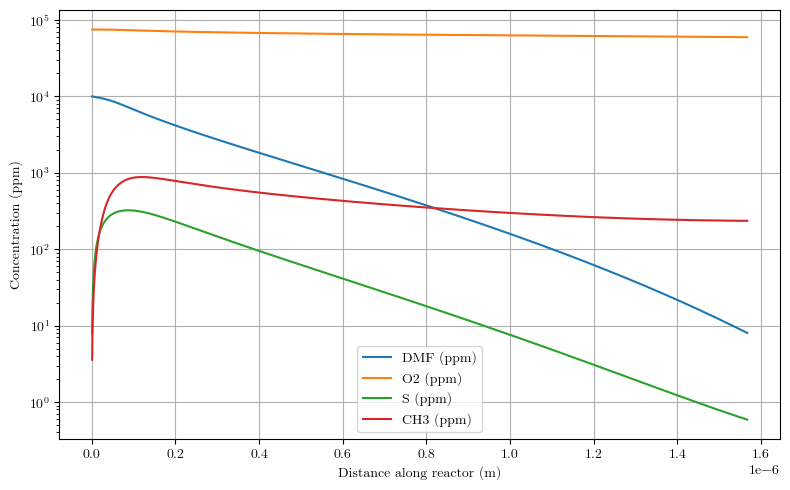

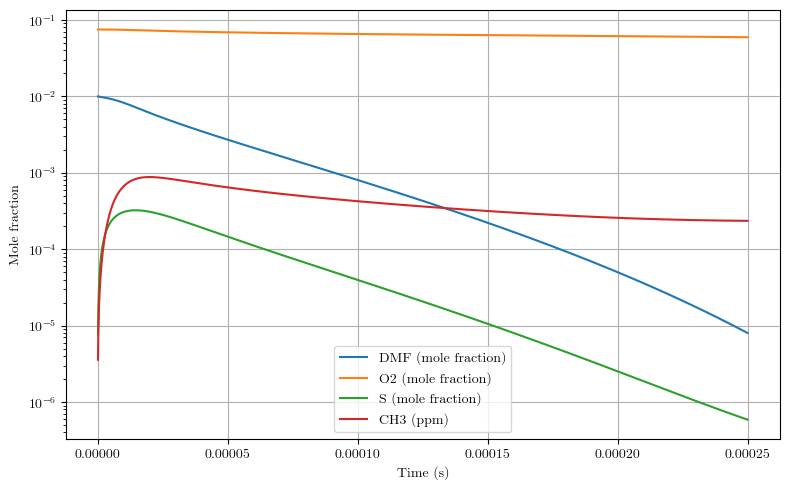

Initial X_DMF = 0.01
Final   X_DMF = 8.013787654356075e-06
Initial X_O2  = 0.075
Final   X_O2  = 0.05941761006789044


In [4]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

# 1. Mechanism + inlet state
gas = ct.Solution(model_path)

T0 = 1500.0  # inlet temperature [K]
P = ct.one_atm

DMF = get_species(gas, "DMF")
O2  = get_species(gas, "O2")
AR  = get_species(gas, "Ar")

inlet = {DMF : 0.01, O2: 0.075, AR: 0.915}

gas.TPX = T0, P, inlet

# 2. Geometry + flow (define a nominal PFR)
length = 1.5e-6   # reactor length [m]
area   = 1.0e-4 # cross-sectional area [m^2]
u0     = 0.006    # inlet velocity [m/s]

rho0 = gas.density
mdot = rho0 * u0 * area      # constant mass flow rate [kg/s]

# 3. Lagrangian PFR: follow a fluid element in time, map t -> z
r = ct.IdealGasConstPressureReactor(gas, energy="on")
sim = ct.ReactorNet([r])

# Total "flight time" if velocity ~ u0
t_end = length / u0
N_pts = 2000  # axial resolution (number of sample points)

z_list  = []
t_list   = [] # time history
DMF_list = []
O2_list  = []
S_list  = []
CHHH_list = []

S_target = "S(1278)"   # example: replace with the one you want
i_S = gas.species_index(S_target)
CHHH_target = "CH3(23)" 
i_CHHH = gas.species_index(CHHH_target)

t_old = 0.0
z = 0.0

for k in range(N_pts):
    # Advance to the next target time
    t_target = (k + 1) / N_pts * t_end
    sim.advance(t_target)

    dt = t_target - t_old
    # Recompute density and velocity (u may change as composition changes)
    rho = r.thermo.density
    u   = mdot / (rho * area)
    z  += u * dt
    t_old = t_target

    z_list.append(z)
    t_list.append(t_target)
    DMF_list.append(r.thermo[DMF].X[0])
    O2_list.append(r.thermo[O2].X[0])
    S_list.append(r.thermo[i_S].X[0])
    CHHH_list.append(r.thermo[i_CHHH].X[0])
    

z = np.array(z_list)
t = np.array(t_list)
DMF_arr = np.array(DMF_list)
O2_arr = np.array(O2_list)
S_arr = np.array(S_list)
CHHH_arr = np.array(CHHH_list)

# --- Plot vs distance (PFR-style) ---
plt.figure(figsize=(8, 5))
plt.semilogy(z, DMF_arr * 1e6, label="DMF (ppm)")
plt.semilogy(z, O2_arr * 1e6, label="O2 (ppm)")
plt.semilogy(z, S_arr * 1e6, label="S (ppm)")  # rename to whatever S actually is
plt.semilogy(z, CHHH_arr * 1e6, label="CH3 (ppm)")  # rename to whatever S actually is
plt.xlabel("Distance along reactor (m)")
plt.ylabel("Concentration (ppm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# --- Plot vs time (Lagrangian / batch-reactor view) ---
plt.figure(figsize=(8, 5))
plt.semilogy(t, DMF_arr, label="DMF (mole fraction)")
plt.semilogy(t, O2_arr,  label="O2 (mole fraction)")
plt.semilogy(t, S_arr,   label="S (mole fraction)")
plt.semilogy(t, CHHH_arr, label="CH3 (ppm)")  # rename to whatever S actually is
plt.xlabel("Time (s)")
plt.ylabel("Mole fraction")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
print("Initial X_DMF =", inlet[DMF])
print("Final   X_DMF =", DMF_arr[-1])
print("Initial X_O2  =", inlet[O2])
print("Final   X_O2  =", O2_arr[-1])

